# Week 9 – Gradient Boost

This notebook focuses on concepts such as such as gradient boost, learning rate, number of estimators, tree depth, and regularization.

In this notebook, I apply Gradient Boosting Regression to predict hospital length of stay. Gradient Boosting is a powerful ensemble method that builds a series of small decision trees, where each one tries to fix the mistakes of the previous one. Since it often outperforms simpler models, I'm using it to see if I can improve predictions compared to earlier approaches like KNN and Elastic Net. I start by scaling the data, then train a baseline model, and finally fine-tune key parameters like the number of trees, tree depth, learning rate, and feature selection. The goal is to find a boosted model that gives solid performance without overfitting.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('LengthOfStay.csv')
df

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,1/28/2012,3,M,0,0,0,0,0,0,...,171.422555,12.0,0.650323,30.063069,80,6.5,1,2/3/2012,B,6
99996,99997,8/6/2012,0,M,0,0,0,0,0,0,...,122.342450,12.0,1.521424,28.969548,61,6.5,1,8/7/2012,B,1
99997,99998,7/23/2012,1,M,0,0,1,0,0,0,...,108.288106,12.0,1.025677,26.354919,61,6.9,1,7/27/2012,C,4
99998,99999,12/19/2012,0,M,0,0,0,0,0,0,...,111.750731,16.0,1.035400,29.193462,59,5.6,1,12/23/2012,B,4


Replace '5+' with '5' in the rcount column, drop unnecessary columns, encode categorical columns and split features and target, which is the lenght of stay at the hospital.

In [8]:
df['rcount'] = df['rcount'].replace('5+', 5).astype(int)

df_clean = df.drop(columns=['eid', 'vdate', 'discharged'])

df_encoded = pd.get_dummies(df_clean, columns=['gender', 'facid'], drop_first=True)

X = df_encoded.drop(columns='lengthofstay')
y = df_encoded['lengthofstay']

Split train and test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Baseline Gradient Boosting Regressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

RMSE: 0.60
R2: 0.93


Even before tunnig, these results are great! The average prediction error is less than 1 day of Length of Stay and the model explains 93% oof the variance in Length of Stay.

Now I will tun the model's paramters with GridSearch. The parameters include: n_estimators (number of trees), learning_rate, max_depth (tree depth) and min_samples_leaf (regularization).

In [24]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 4, 5],
    'min_samples_leaf': [1, 3, 5]
}

gbr = GradientBoostingRegressor(random_state=42)

grid = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}


Now I will run the model again using the best parameters for the model.

In [25]:
best_gbr = grid.best_estimator_

y_pred_best = best_gbr.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Best RMSE: {rmse_best:.2f}")
print(f"Best R²: {r2_best:.2f}")

Best RMSE: 0.43
Best R²: 0.97


## Conclusion

This week I used Gradient Boosting Regression to predict hospital Length of Stay. The baseline model already did pretty well, with an RMSE of 0.60 and an R² of 0.93. After tuning the learning rate, number of trees, and tree depth, the results got even better. The final model, with 200 trees, a learning rate of 0.1, and depth-5 trees, ended up with an RMSE of just 0.43 and an R² of 0.97 on the test set. This was by far the best model I’ve tried so far, and it shows how powerful gradient boosting can be when you spend time tuning it properly. Overall, this was a great example of how boosting can really improve prediction accuracy.

## Top 15 most important features

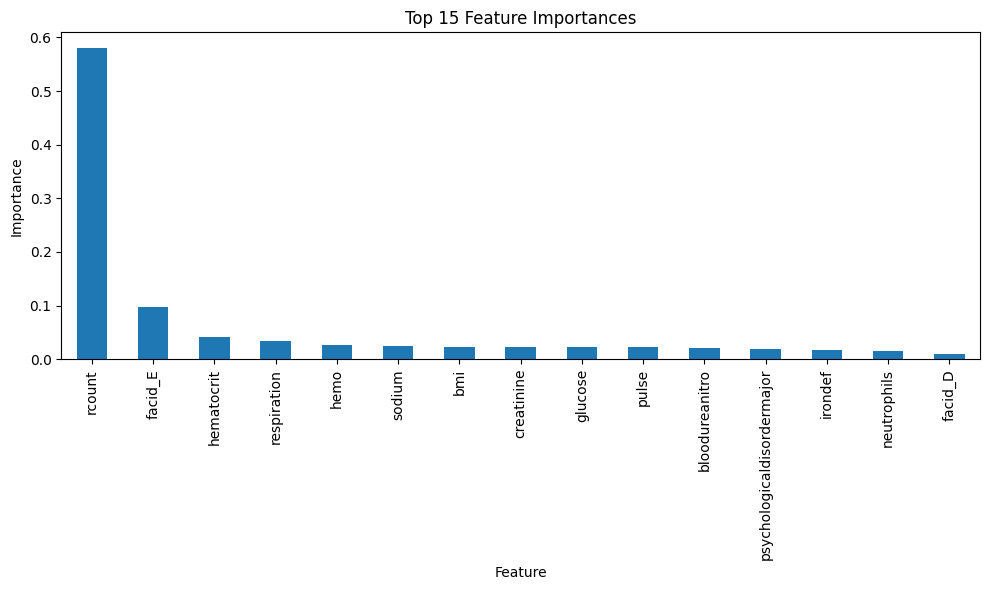

In [26]:
feature_importances = pd.Series(
    best_gbr.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feature_importances.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

The feature importance plot shows that rcount was by far the most important predictor of Length of Stay, contributing over half of the total importance on its own. This suggests that the number of readmissions has a big impact on how long patients stay in the hospital. The facility variable facid_E was the second most influential, indicating that where the patient was treated also mattered. Other features like hematocrit, respiration, glucose, and creatinine added smaller contributions but still helped the model fine-tune its predictions. Overall, while many variables played a role, most of the predictive power came from just a few key features.

